In [25]:
import os 
import xarray as xr
import numpy as np
import glob
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, normalize
import itertools
from numpy.lib.stride_tricks import sliding_window_view
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from scipy.stats import pearsonr


In [2]:
cluster_variables = ['abs_vo600', 'abs_vo850', 'mpi', 'msl', 'r400', 'r600', 'r700', 'r850', 'ssta20', 'ssta30', 'sst', 'vo600', 'vo850', 'vws600-250', 'vws850-200', 'vws_u600-250', 'vws_u850-200', 'vws_v600-250', 'vws_v850-200', 'mgu850', 'mgu600', 'mgv850', 'mgv600', 'zgu850', 'zgu600', 'zgv850', 'zgc600', 'w']
len(cluster_variables)

28

In [3]:
n_clusters = 6
n_vars = 14
n_idxs = 10
results_folder = f'test_nc{n_clusters}_nv{n_vars}_nd{n_idxs}'
basin = 'GLB'
model_kind = 'LinReg'
n_folds = 5
start_year = 1980
end_year = 2021

# Set project directory and name of file containing the target variable
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
target_file = 'target_1965-2022_2.5x2.5.csv'

# Set the paths to the files
experiment_filename = f'1965-2022_{n_clusters}clusters_{n_vars}vars_{n_idxs}idxs.csv'
sol_filename = f'{model_kind}_' + experiment_filename
predictor_file = 'predictors_' + experiment_filename
fs_dir = os.path.join(project_dir, 'FS_TCG')
output_dir = os.path.join(fs_dir, 'results', results_folder)
sol_path = os.path.join(output_dir, sol_filename)
# final_sol_path = os.path.join(output_dir, f'CRO_{sol_filename}')
data_dir = os.path.join(fs_dir, 'data', f'{basin}_{n_clusters}clusters')
predictors_path = os.path.join(data_dir, predictor_file)
target_path = os.path.join(data_dir, target_file)
results_figure_dir = os.path.join(output_dir, 'figures')
os.makedirs(results_figure_dir, exist_ok=True)

# Load the predictors and the target in a DataFrame
predictors_df = pd.read_csv(predictors_path, index_col=0)
predictors_df.index = pd.to_datetime(predictors_df.index)
target_df = pd.read_csv(target_path, index_col=0)
target_df.index = pd.to_datetime(target_df.index)

# Load the labels files and plot the clusters for each atmospheric variable
files_labels = os.listdir(data_dir)
files_labels = [file for file in files_labels if file.startswith('label')]
files_labels.sort()

# Load the solutione file in a DataFrame
sol_file_df = pd.read_csv(sol_path, sep=' ', header=0)

# Find solutions with best performance both for Cross-Validation and Test metric
CVbest = sol_file_df['CV'].idxmin() # metric is mean squared error
Testbest = sol_file_df['Test'].idxmin()
array_bestCV = np.fromstring(sol_file_df['Sol'][CVbest].replace('[', '').replace(']', '').replace('\n', ''), dtype=float, sep=' ')

In [4]:
# Select the variables from the best solutions and plot it
column_names = predictors_df.columns.tolist()
final_sequence = array_bestCV[len(column_names):2*len(column_names)]
sequence_length = array_bestCV[:len(column_names)]
feat_sel = array_bestCV[2*len(column_names):]

In [5]:
variable_selection = feat_sel.astype(int)
time_sequences = sequence_length.astype(int)
time_lags = final_sequence.astype(int)
dataset_opt = target_df.copy()
label_selected_vars = []
for c, col in enumerate(predictors_df.columns):
    if variable_selection[c] == 0 or time_sequences[c] == 0:
        continue
    for j in range(time_sequences[c]):
        dataset_opt[str(col) +'_lag'+ str(time_lags[c]+j)] = predictors_df[col].shift(time_lags[c]+j)
        label_selected_vars.append(str(col) +'_lag'+ str(time_lags[c]+j))

In [6]:
variables_with_cluster = [var for var in label_selected_vars if 'cluster' in var]
variable_names = [var.split('_cluster')[0] for var in variables_with_cluster]
variable_names = list(set(variable_names))
variable_names.sort()
variable_names

['abs_vo600',
 'abs_vo850',
 'mpi',
 'msl',
 'r700',
 'r850',
 'sst',
 'ssta20',
 'ssta30',
 'vo600',
 'vo850',
 'vws600-250',
 'vws850-200',
 'w']

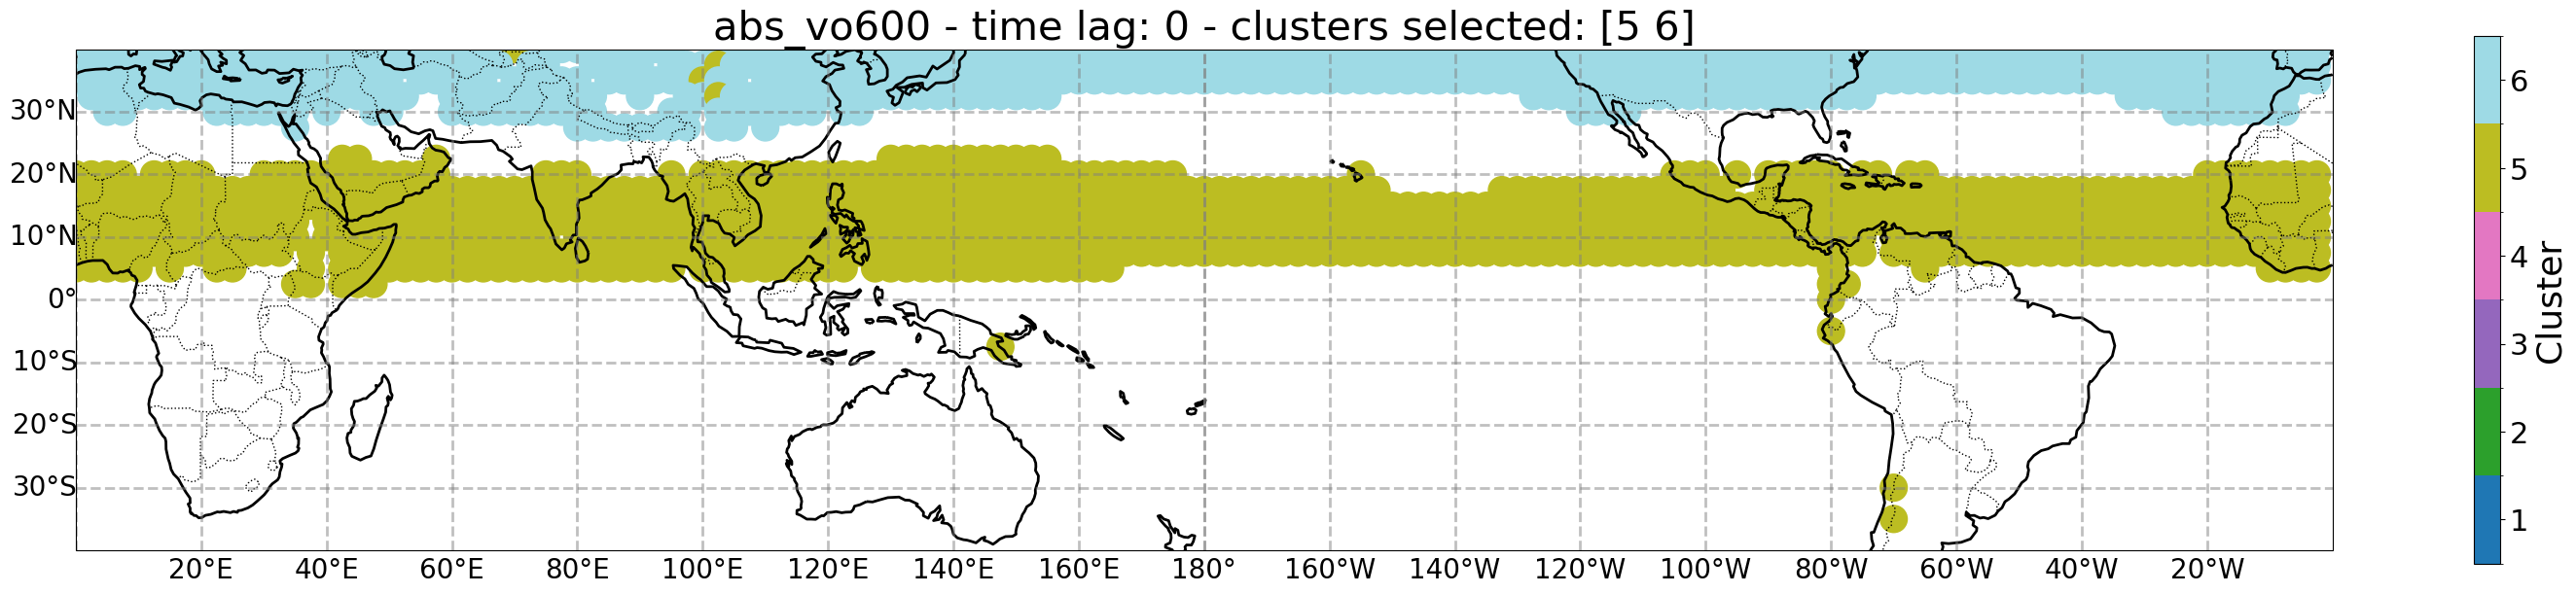

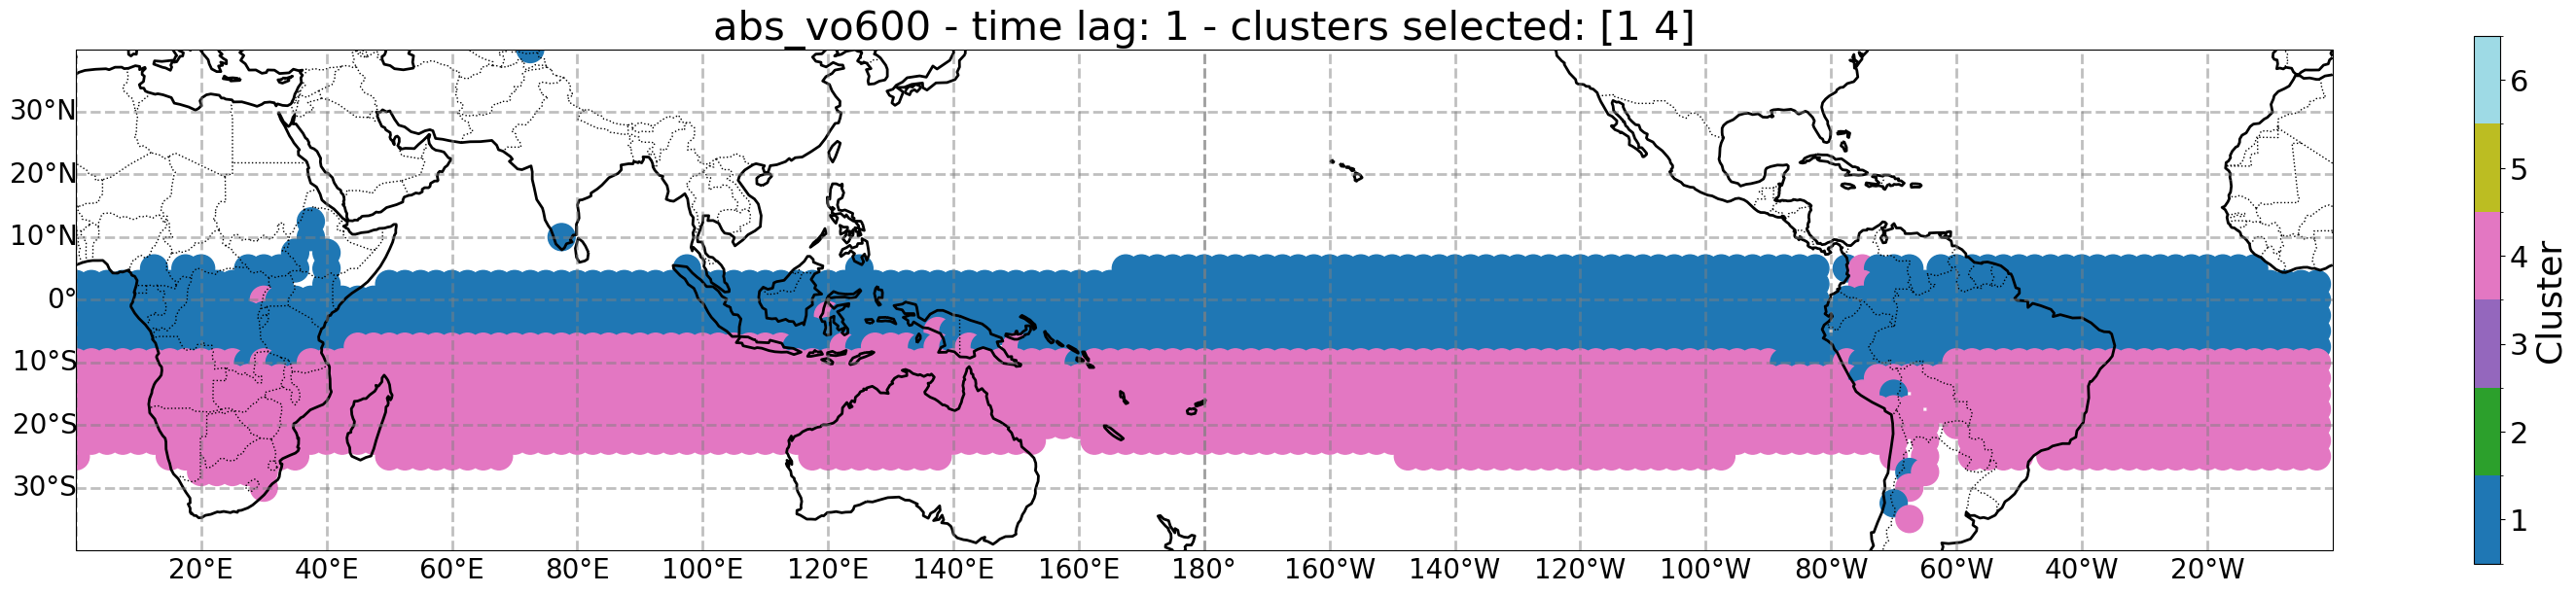

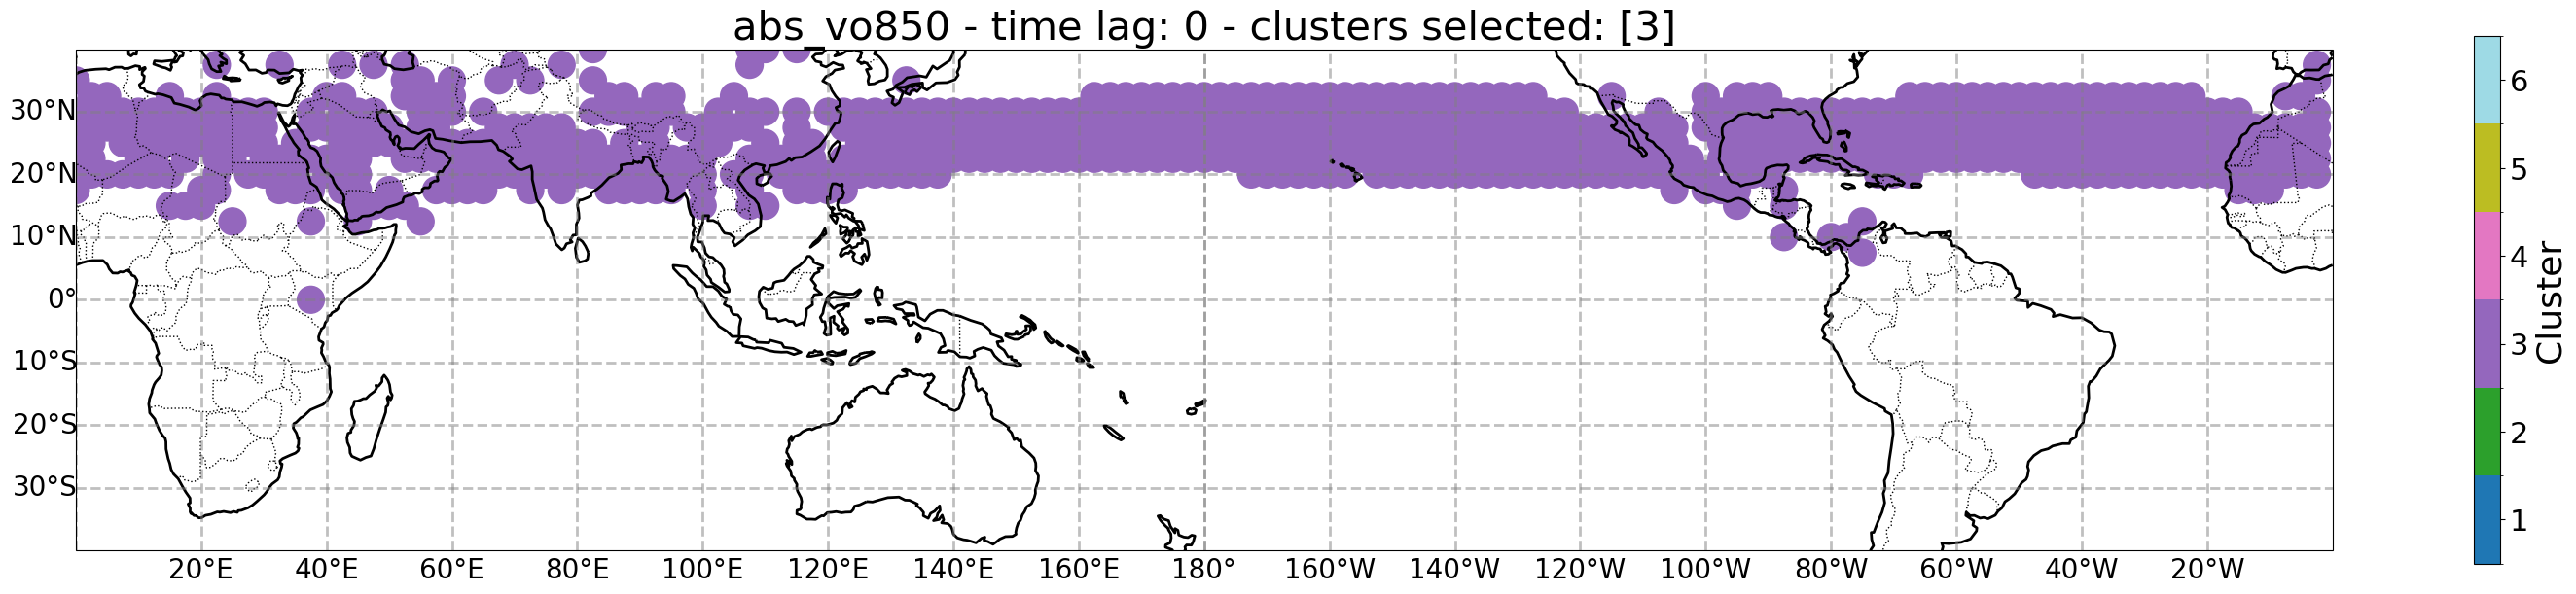

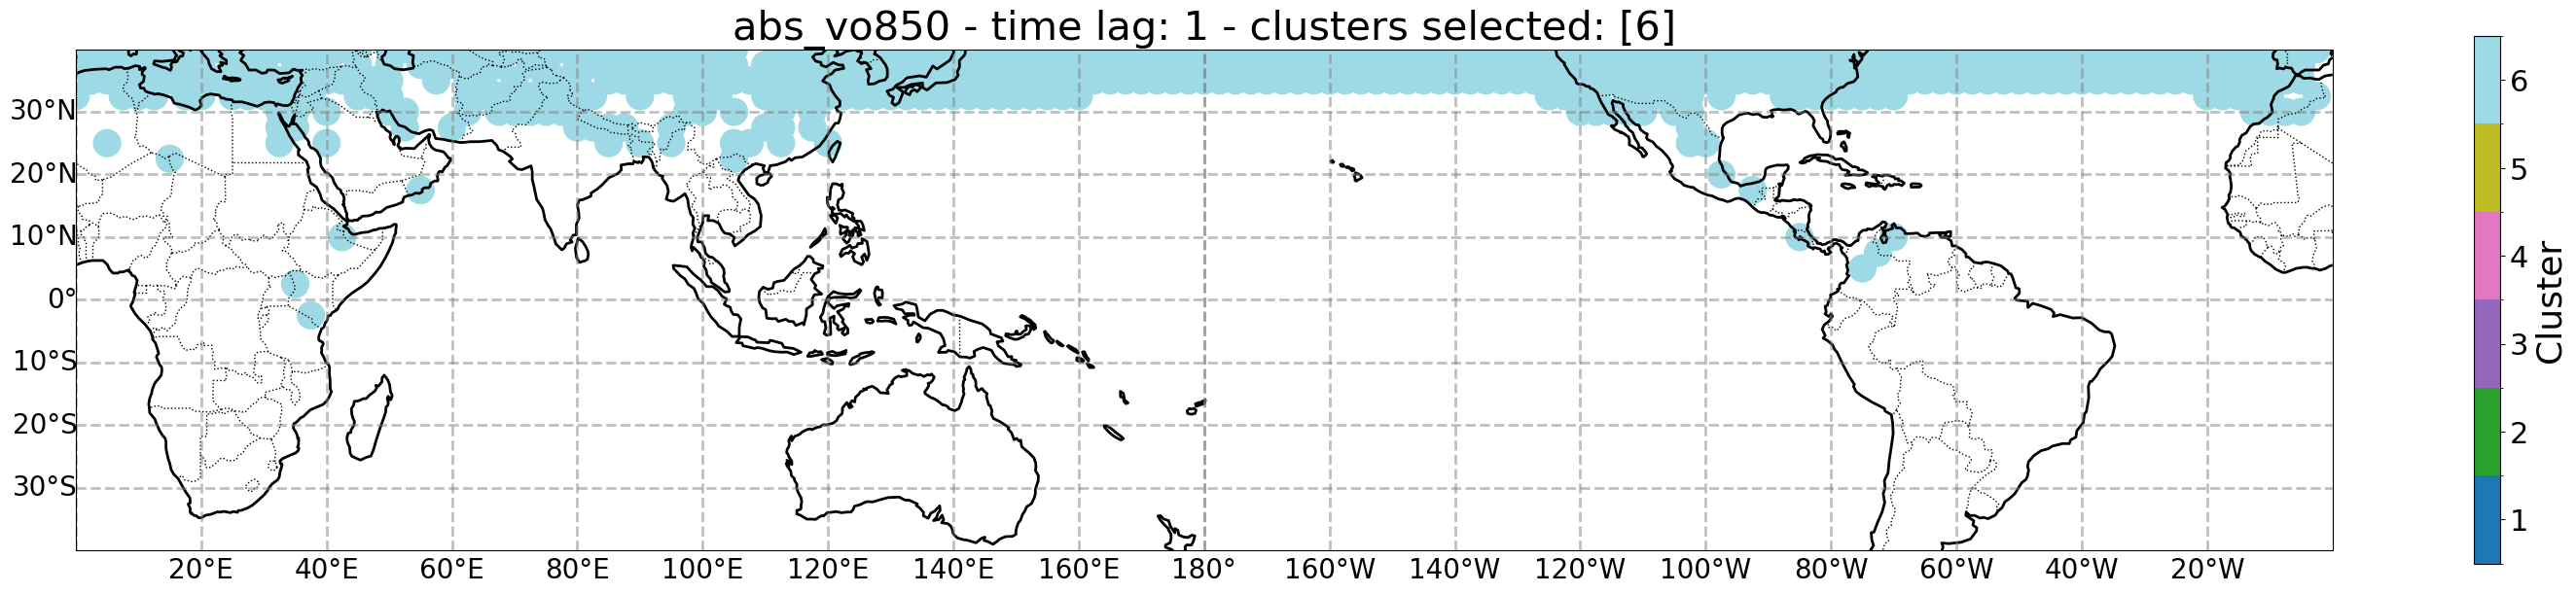

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.colors as mcolors

for v, var in enumerate(variable_names):
    # Load the labels file
    label_file = f'labels_{var}.csv'
    label_df = pd.read_csv(os.path.join(data_dir, label_file), index_col=0)
    unique_clusters = np.arange(1, n_clusters+1)

    # Define a color map with fixed colors for each cluster and map the clusters to the colors index
    cmap = plt.get_cmap('tab20', n_clusters)
    colors = cmap(np.linspace(0, 1, n_clusters))
    full_cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(np.arange(n_clusters + 1) - 0.5, n_clusters)
    cluster_to_color_index = {cluster: i for i, cluster in enumerate(unique_clusters)}

    # Determine the clusters and corresponding lags selected for the variable
    clusters_selected = np.asarray([int(long_name.split('_cluster')[1].split('_lag')[0]) 
                                    for long_name in label_selected_vars if long_name.split('_cluster')[0] == var])
    time_lags_selected = np.asarray([int(long_name.split('_lag')[1]) 
                                     for long_name in label_selected_vars if long_name.split('_cluster')[0] == var])
    
    # Set the domain extension of the figures
    north, south = label_df['nodes_lat'].iloc[0], label_df['nodes_lat'].iloc[-1]
    west, east = label_df['nodes_lon'].iloc[0], label_df['nodes_lon'].iloc[-1]
    
    # Cycle through the lags and select the clusters for each lag
    for lag in np.arange(2):
        clusters_for_lag = clusters_selected[time_lags_selected == lag] 
        # Plot the clusters for the selected variable and lag only if there are clusters selected
        if len(clusters_for_lag) > 0:
            # Select the rows of the label file that correspond to the selected clusters
            label_df_selected = label_df[label_df['cluster'].isin(clusters_for_lag)]
            
            # Set the figure and gridlines of the map
            fig = plt.figure(figsize=(30, 6))
            ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
            ax.set_extent([west, east, south, north], crs=ccrs.PlateCarree())
            ax.coastlines(resolution='110m', linewidth=2)
            ax.add_feature(cfeature.BORDERS, linestyle=':')
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False
            gl.xformatter = LongitudeFormatter()
            gl.yformatter = LatitudeFormatter()
            gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 20))
            gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, 10))
            gl.xlabel_style = {'size': 20} 
            gl.ylabel_style = {'size': 20}

            # Plot only the selected clusters using their index in the full color map
            scatter = ax.scatter(
                label_df_selected['nodes_lon'].values, 
                label_df_selected['nodes_lat'].values,
                c=[cluster_to_color_index[cluster] for cluster in label_df_selected['cluster']],
                cmap=full_cmap, norm=norm, s=400, transform=ccrs.PlateCarree()
            )

            # Create a colorbar showing all clusters
            cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', ticks=np.arange(n_clusters))
            cbar.set_ticklabels(unique_clusters)
            cbar.ax.tick_params(labelsize=22)
            cbar.set_label('Cluster', fontsize=26)

            ax.set_title(f'{var} - time lag: {lag}', fontsize=30)
            plt.tight_layout()

            # Save the figure
            fig_name = f'{var}_lag{lag}_clusters_selected.pdf'
            fig_path = os.path.join(results_figure_dir, fig_name)
            plt.savefig(fig_path, format='pdf', dpi=300)

            plt.close()

    if v == 1:
        break

In [46]:
unique_clusters = sorted(label_df['cluster'].unique())  # Get unique cluster labels
n_clusters = len(unique_clusters)

In [49]:
unique_clusters

[1, 2, 3, 4, 5, 6]

In [50]:
np.arange(1, n_clusters+1)

array([1, 2, 3, 4, 5, 6])

In [52]:
np.linspace(0, 1, n_clusters)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])